In [1]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import os
import torch
import cv2
import time
import matplotlib.pyplot as plt

from utils.init_models import initialize_model

import numpy as np
import os

import nibabel as nib

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss, parameter

from torch.utils.data import Dataset,DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from catalyst.dl import SupervisedRunner, TensorboardLogger
from catalyst.callbacks import SchedulerCallback, CheckpointCallback
from catalyst import dl, metrics, utils
from catalyst.data import BatchPrefetchLoaderWrapper
from catalyst import dl

from catalyst.utils.distributed import get_nn_from_ddp_module
from catalyst.utils.misc import maybe_recursive_call
from catalyst.contrib.nn.criterion.dice import DiceLoss

from utils.get_data_list import get_3d_data_list
from utils.Dataset import my_3d_dataset

from utils.get_data_list import get_data_list
from utils.Dataset import my_dataset

from skimage.metrics import structural_similarity as ssim

from tensorboard.backend.event_processing import event_accumulator
import argparse
import pandas as pd
from tqdm import tqdm

import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

/data/users2/yxiao11/anaconda3/envs/p37/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
resize = 128
num_colors = 8

image_dataset, mask_dataset = get_data_list(['Add_mri_deface'])
# image_3d_dataset, mask_3d_dataset = get_3d_data_list(['Addiction'])
train_here_dataset = my_dataset(
            img_list = image_dataset, 
            msk_list = mask_dataset,
            resize = resize,
            num_colors = num_colors,
         
            )

In [3]:
index = 10
# image = nib.load(image_3d_dataset[index])
# image = image.get_fdata()
# image = image[:,:,96]
tensors = train_here_dataset.__getitem__(index)

ipt = tensors['image']
msk = tensors['mask']
tgt = tensors['target']

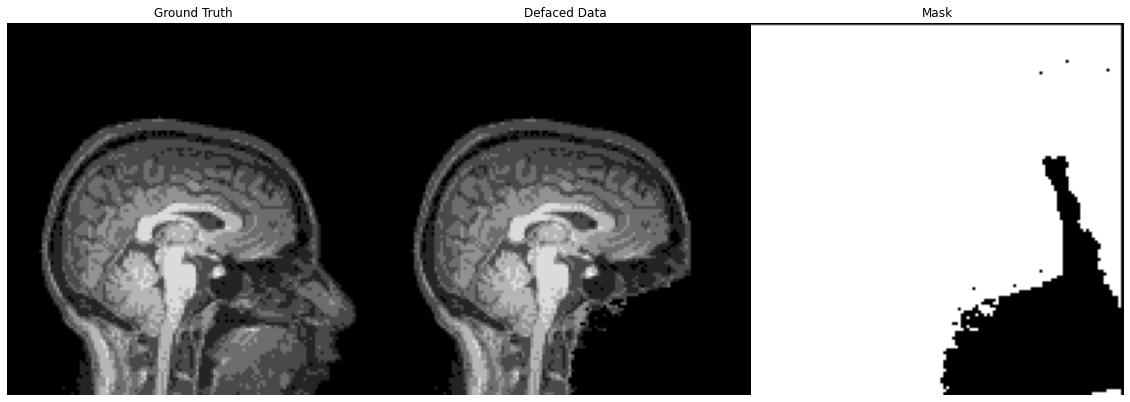

In [4]:

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(np.rot90(tgt[0]), cmap='gray')
plt.axis('off')
plt.title('Ground Truth')

plt.subplot(1,3,2)
plt.imshow(np.rot90(msk[0]), cmap='gray')
plt.axis('off')
plt.title('Defaced Data')

plt.subplot(1,3,3)
plt.imshow(np.rot90(msk[1]), cmap='gray')
plt.axis('off')
plt.title('Mask')



plt.subplots_adjust(wspace=0,hspace=0)

NameError: name 'image' is not defined

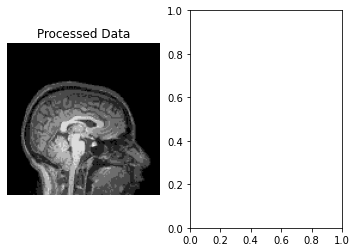

In [5]:
plt.subplot(1,2,1)
plt.imshow(np.rot90(ipt[0]), cmap='gray')
plt.axis('off')
plt.title('Processed Data')

plt.subplot(1,2,2)
plt.imshow(np.fliplr(np.rot90(image)), cmap='gray')
plt.axis('off')
plt.title('Ground Truth')

plt.subplots_adjust(wspace=0,hspace=0)

In [6]:
class my_ss_dataset(Dataset):
    def __init__(
        self, 
        img_list: list,
        msk_list: list,
        resize: int,
        num_colors: int,
    ):
          
        self.img_list = img_list
        self.msk_list = msk_list
        self.resize = resize
        self.num_colors = num_colors
       
        
    def __getitem__(self, item):
        
        
        
        mask = np.load(self.msk_list[item])
        mask = np.floor(cv2.resize(mask, dsize=(self.resize, self.resize)))
#         mask = mask.get_fdata()
#         mask = self.__crop__(mask, slices, 'mask')
#         mask = np.flip(mask, axis=-1)
        
        
        image = np.load(self.img_list[item])
        image = cv2.resize(image, dsize=(self.resize, self.resize))
#         image = image.get_fdata()
#         image = self.__crop__(image, slices, 'image')
#         image = np.rot90(image, k=2)
        image_target = np.around(image/image.max()*(self.num_colors-1))
        
#         image_prior = (image_target - image_target.min()) / (image_target.max() - image_target.min())
        
#         prior = image_prior.copy()
        
        ipt = image_target*mask
    
        
    
        
        
        
        
        return {'image':image_target, 'mask':ipt}
    
    def __len__(self):
           
        return len(self.img_list)
    
    def __crop__(self, img, coords, label):
        if label == 'mask':
            tgt_cube = cv2.resize(img[coords,:,:], dsize=(self.resize, self.resize))
        if label == 'image':
            tgt_cube = cv2.resize(img[:,:,coords], dsize=(self.resize, self.resize))
        return tgt_cube

In [7]:
resize = 128
num_colors=8

image_dataset, mask_dataset = get_data_list(['Addiction'])
train_dataset = my_ss_dataset(
            img_list = image_dataset, 
            msk_list = mask_dataset,
            resize = resize,
            num_colors = num_colors,
         
            )

In [8]:
index = 841
ss = train_dataset.__getitem__(index)

gen = np.load('/data/users2/yxiao11/model/pix_con/generated_data/output%s.npy'%(index))

img = ss['image']
msk = ss['mask']

(-0.5, 127.5, 127.5, -0.5)

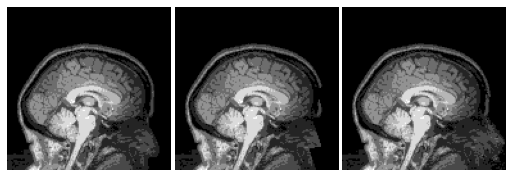

In [9]:
plt.figure(figsize=(9,3))
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplot(1,3,1)
plt.imshow(np.rot90(img), cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.rot90(msk), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.rot90(gen), cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

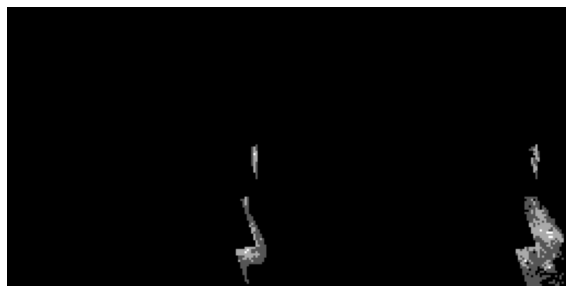

In [10]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplot(1,2,1)
plt.imshow(np.rot90(img-msk), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(gen-msk), cmap='gray')
plt.axis('off')

In [11]:
ssim_opt_list = []
ssim_msk_list = []
for i in range(801, 946):
    index = i
    ss = train_dataset.__getitem__(index)

    gen = np.load('/data/users2/yxiao11/model/pix_con/generated_data/output%s.npy'%(index))
#     msk = np.load('/data/users2/yxiao11/model/pix_con/generated_data/target%s.npy'%(index))

    img = ss['image']
    msk = ss['mask']
    
    ssim_opt = ssim(img, gen)
    ssim_msk = ssim(img, msk)
    
    ssim_opt_list.append(ssim_opt)
    ssim_msk_list.append(ssim_msk)

    
for i in range(145):
    if ssim_msk_list[i]>ssim_opt_list[1]:
        print(i)

/data/users2/yxiao11/anaconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]


32
40


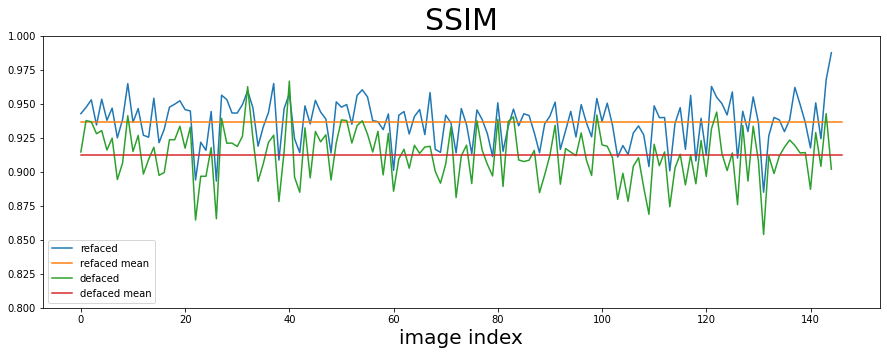

In [26]:
opt_mean = np.mean(ssim_opt_list)
msk_mean = np.mean(ssim_msk_list)

plt.figure(figsize=(15,5))
plt.plot(ssim_opt_list, label='refaced')
plt.plot([0,146],[opt_mean,opt_mean], label='refaced mean')
plt.plot(ssim_msk_list, label='defaced')
plt.plot([0,146],[msk_mean,msk_mean], label='defaced mean')
plt.ylim(0.8, 1)
plt.legend(loc="lower left")
plt.xlabel('image index', fontsize=20)
plt.title('SSIM', fontsize=30)
plt.show()

In [13]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

mse_opt_list = []
mse_msk_list = []
for i in range(801, 946):
    index = i
    ss = train_dataset.__getitem__(index)

    gen = np.load('/data/users2/yxiao11/model/pix_con/generated_data/output%s.npy'%(index))
#     msk = np.load('/data/users2/yxiao11/model/pix_con/generated_data/target%s.npy'%(index))

    img = ss['image']
    msk = ss['mask']
    
#     mse_opt = mean_squared_error(img, gen)
#     mse_msk = mean_squared_error(img, msk)
#     mse_opt = np.sum(np.sqrt((img-gen)**2))/msk.sum()
#     mse_msk = np.sum(np.sqrt((img-msk)**2))/msk.sum()
    mse_opt = corr2(img, gen)
    mse_msk = corr2(img, msk)
    
    mse_opt_list.append(mse_opt)
    mse_msk_list.append(mse_msk)
    

for i in range(145):
    if mse_msk_list[i]>mse_opt_list[1]:
        print(i)

40


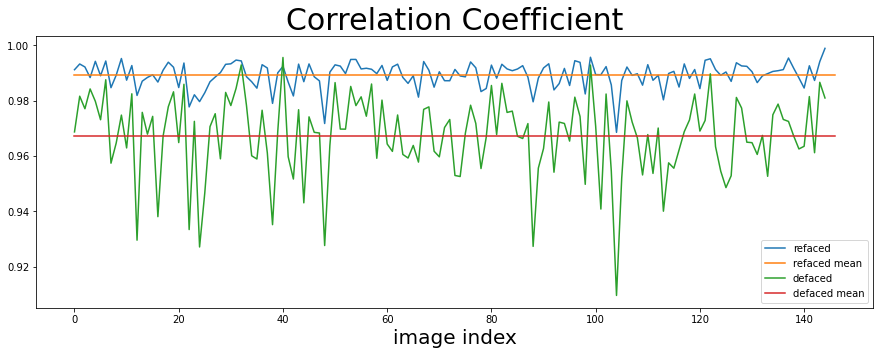

In [25]:
opt_mean = np.mean(mse_opt_list)
msk_mean = np.mean(mse_msk_list)

plt.figure(figsize=(15,5))
plt.plot(mse_opt_list, label='refaced')
plt.plot([0,146],[opt_mean,opt_mean], label='refaced mean')
plt.plot(mse_msk_list, label='defaced')
plt.plot([0,146],[msk_mean,msk_mean], label='defaced mean')
# plt.ylim(0.8, 1)
plt.legend(loc="lower right")
plt.xlabel('image index', fontsize=20)
plt.title('Correlation Coefficient', fontsize=30)
plt.show()

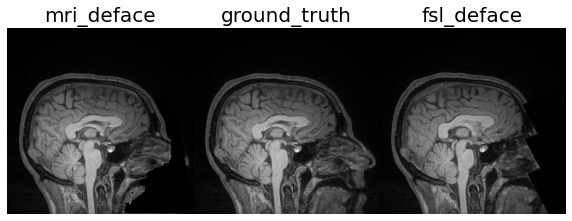

In [16]:
file_name = os.listdir('/data/users2/yxiao11/data/add_mrideface/mri_data')

index = 30
deface_mri_add = '/data/users2/yxiao11/data/add_mrideface/deface_dataset/' + file_name[index]
ground_truth = '/data/users2/yxiao11/data/add_mrideface/mri_data/' + file_name[index]
deface_fsl_add = '/data/users2/yxiao11/data/Addiction/deface_dataset//' + file_name[index]


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(np.rot90(np.load(deface_mri_add)), cmap='gray')
plt.title('mri_deface', fontsize=20)
plt.axis('off')


plt.subplot(1,3,2)
plt.imshow(np.rot90(np.load(ground_truth)), cmap='gray')
plt.title('ground_truth', fontsize=20)
plt.axis('off')


plt.subplot(1,3,3)
plt.imshow(np.rot90(np.load(deface_fsl_add)), cmap='gray')
plt.title('fsl_deface', fontsize=20)
plt.axis('off')


plt.subplots_adjust(wspace=0,hspace=0)

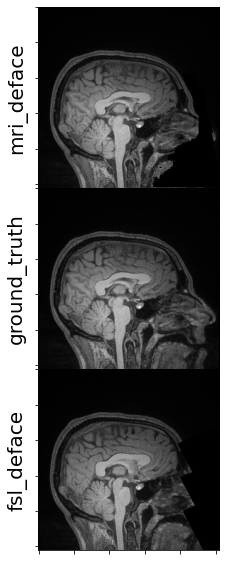

In [15]:
file_name = os.listdir('/data/users2/yxiao11/data/add_mrideface/mri_data')

index = 30
deface_mri_add = '/data/users2/yxiao11/data/add_mrideface/deface_dataset/' + file_name[index]
ground_truth = '/data/users2/yxiao11/data/add_mrideface/mri_data/' + file_name[index]
deface_fsl_add = '/data/users2/yxiao11/data/Addiction/deface_dataset//' + file_name[index]


plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow(np.rot90(np.load(deface_mri_add)), cmap='gray')
plt.ylabel('mri_deface', fontsize=20)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.imshow(np.rot90(np.load(ground_truth)), cmap='gray')
plt.ylabel('ground_truth', fontsize=20)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.imshow(np.rot90(np.load(deface_fsl_add)), cmap='gray')
plt.ylabel('fsl_deface', fontsize=20)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.subplots_adjust(wspace=0,hspace=0)

In [63]:


file_name = os.listdir('/data/users2/yxiao11/data/add_mrideface/deface_dataset')

ssim_mri_deface = []
ssim_fsl_deface = []
for i in range(800):
    index = i
    
    org_path = '/data/users2/yxiao11/data/add_mrideface/mri_data/' + file_name[i]
    mri_path = '/data/users2/yxiao11/data/add_mrideface/deface_dataset/' + file_name[i]
    fsl_path = '/data/users2/yxiao11/data/Addiction/deface_dataset/' + file_name[i]
    
    org_image = np.load(org_path)
    mri_image = np.load(mri_path)
    fsl_image = np.load(fsl_path)
 
    ssim_mri = ssim(org_image, mri_image)
    ssim_fsl = ssim(org_image, fsl_image)
    
    ssim_mri_deface.append(ssim_mri)
    ssim_fsl_deface.append(ssim_fsl)

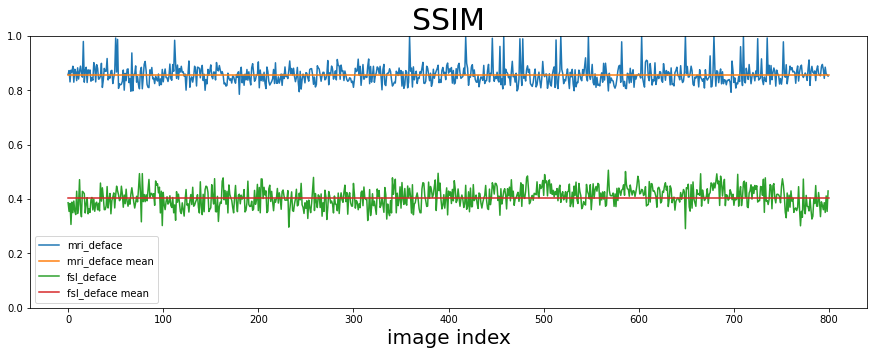

In [21]:
mri_mean = np.mean(ssim_mri_deface)
fsl_mean = np.mean(ssim_fsl_deface)

plt.figure(figsize=(15,5))
plt.plot(ssim_mri_deface, label='mri_deface')
plt.plot([0,800],[mri_mean,mri_mean], label='mri_deface mean')
plt.plot(ssim_fsl_deface, label='fsl_deface')
plt.plot([0,800],[fsl_mean,fsl_mean], label='fsl_deface mean')
plt.ylim(0, 1)
plt.legend(loc="lower left")
plt.xlabel('image index', fontsize=20)
plt.title('SSIM', fontsize=30)
plt.show()

In [56]:
file_name = os.listdir('/data/users2/yxiao11/data/add_mrideface/deface_dataset')

ssim_mri_deface = []
ssim_fsl_deface = []
for i in range(800):
    index = i
    
    org_path = '/data/users2/yxiao11/data/add_mrideface/mri_data/' + file_name[i]
    mri_path = '/data/users2/yxiao11/data/add_mrideface/mask/' + file_name[i]
    fsl_path = '/data/users2/yxiao11/data/Addiction/mask/' + file_name[i]
    
    org_image = cv2.resize(np.load(org_path), (128,128))
    org_image = np.around(org_image/org_image.max()*(8-1))
    mri_mask = np.floor(cv2.resize(np.load(mri_path),(128,128)))
    fsl_mask = np.floor(cv2.resize(np.load(fsl_path),(128,128)))
    
    mri_image = org_image*mri_mask
    fsl_image = org_image*fsl_mask
 
    ssim_mri = ssim(org_image, mri_image)
    ssim_fsl = ssim(org_image, fsl_image)
    
    ssim_mri_deface.append(ssim_mri)
    ssim_fsl_deface.append(ssim_fsl)


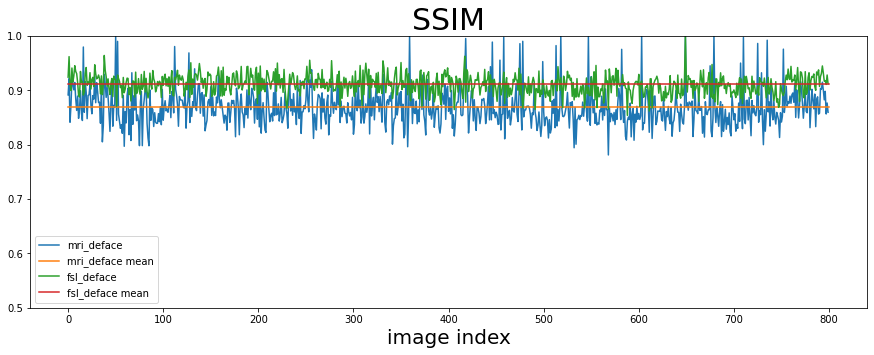

In [58]:
mri_mean = np.mean(ssim_mri_deface)
fsl_mean = np.mean(ssim_fsl_deface)

plt.figure(figsize=(15,5))
plt.plot(ssim_mri_deface, label='mri_deface')
plt.plot([0,800],[mri_mean,mri_mean], label='mri_deface mean')
plt.plot(ssim_fsl_deface, label='fsl_deface')
plt.plot([0,800],[fsl_mean,fsl_mean], label='fsl_deface mean')
plt.ylim(0.5, 1)
plt.legend(loc="lower left")
plt.xlabel('image index', fontsize=20)
plt.title('SSIM', fontsize=30)
plt.show()